In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn import svm
from sklearn.covariance import EmpiricalCovariance
from sklearn.datasets import fetch_mldata
from sklearn.metrics import confusion_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Détection d'anomalies sur données simulées

In [2]:
# On définit le nombre d'observations, la proportion d'anomalies et les configurations
n = 1000
outliers_fraction = 0.05
configs = [0, 1.5, 4] # Trois différentes configurations des données à séparer
xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
n_inliers = int((1. - outliers_fraction) * n)
n_outliers = int(outliers_fraction * n)
true = np.ones(n, dtype=int)
true[-n_outliers:] = -1

In [3]:
# Différentes valeurs du paramètres nu à tester
osvms = {"nu = 0.01": svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1),
         "nu = 0.05": svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1),
             "nu = 0.5": svm.OneClassSVM(nu=0.5, kernel="rbf", gamma=0.1)}

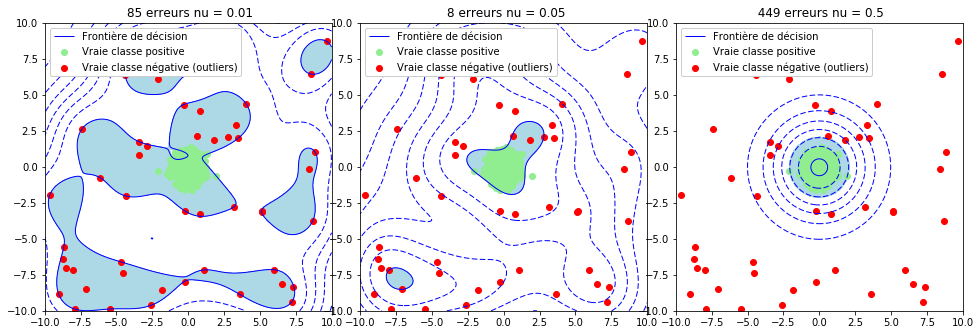

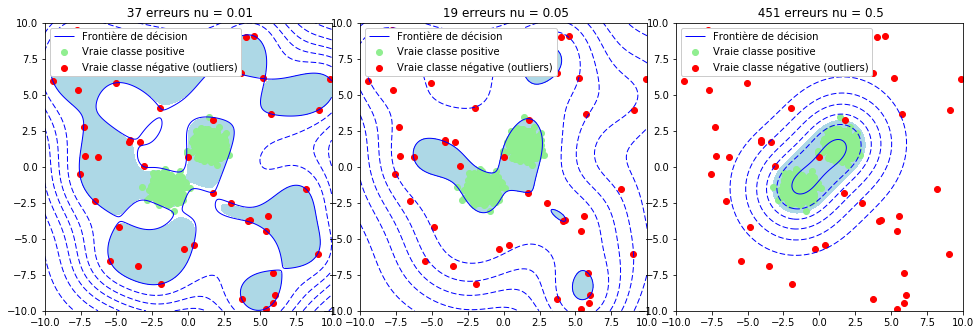

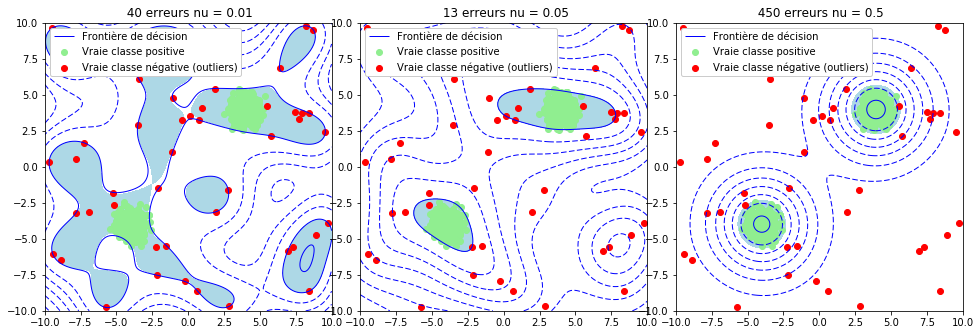

In [4]:
# Detection d'outliers pour les différentes configurations
for i, offset in enumerate(configs):
    
    # Génération des données normales pour les trois configurations
    X1 = 0.5 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.5 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Génération des outliers
    X = np.r_[X, np.random.uniform(low=-10, high=10, size=(n_outliers, 2))]

    # Apprentissage des modèles et représentation graphique des frontières de décisions
    plt.figure(figsize=(15, 5))
    for i, (osvms_name, clf) in enumerate(osvms.items()):
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != true).sum()
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        decision = subplot.contour(xx, yy, Z, linewidths=1, colors='blue')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='lightblue')
        normal = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='lightgreen')
        outliers = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='red')
        subplot.legend(
            [decision.collections[asarray(decision.collections).shape[0] - 1], normal, outliers],
            ['Frontière de décision', 'Vraie classe positive', 'Vraie classe négative (outliers)'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='upper left', framealpha=1)
        subplot.set_title(" %d erreurs %s" % (n_errors, osvms_name))
        subplot.set_xlim((-10, 10))
        subplot.set_ylim((-10, 10))
    plt.subplots_adjust(0.05, 0.1, 0.9, 0.9, 0.1, 0.2)

plt.show()

# 2. Données USPS

In [5]:
X_train = pd.read_table("zip.train.txt", delim_whitespace = True, header = None)
y_train = pd.read_table("zip.train.txt", delim_whitespace = True, header = None).ix[:,0]

X_test = pd.read_table("zip.test.txt", delim_whitespace = True, header = None)
y_test = pd.read_table("zip.test.txt", delim_whitespace = True, header = None).ix[:,0]

## 2.1. Détection d'outliers

In [6]:
# Comme dans Schölkopf et al. (2001) on ajoute 10 indicatrices, une par label
index_dum = pd.get_dummies(X_test[0])
index_dum.columns = range(257, 267)
# Et on retire la colonne de labels originale
X = pd.concat((X_test, index_dum), axis = 1).ix[:,1:]

## 2.1.1. Méthode classique basée sur la distance de Mahalanobis

In [7]:
# Estimation de la covariance empirique des données et calcul de la distance de Mahalanobis
clf =  EmpiricalCovariance(assume_centered=False)
clf.fit(asarray(X))
scores_pred = clf.mahalanobis(asarray(X))

In [8]:
# On retient les 20 pires anomalies selon ce critère
# c'est-à-dire ceux dont la distance est la plus élevée
X["dist"] = scores_pred.flatten()
top_outliers = X.sort_values("dist", ascending= False).head(20).ix[:,:256]

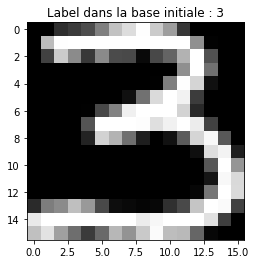

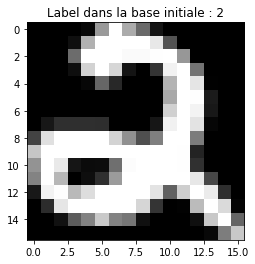

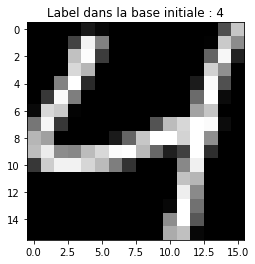

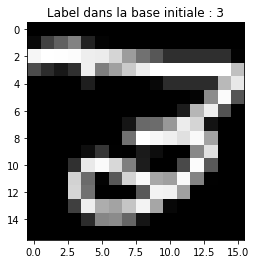

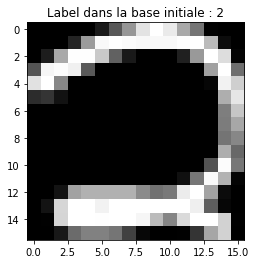

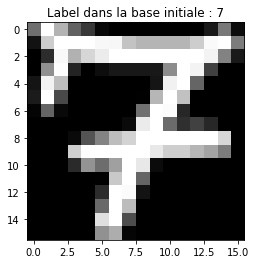

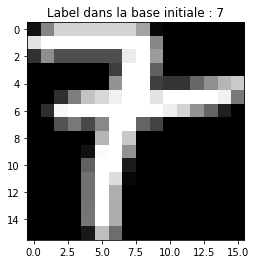

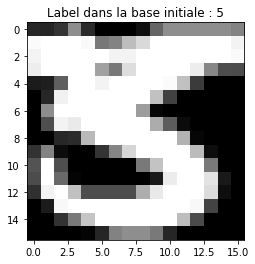

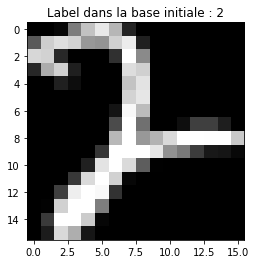

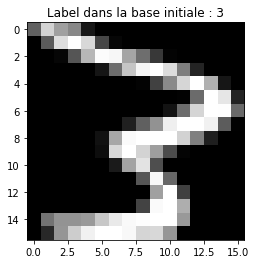

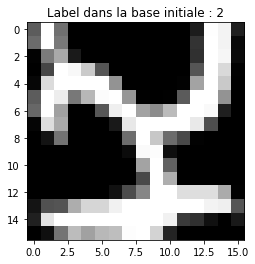

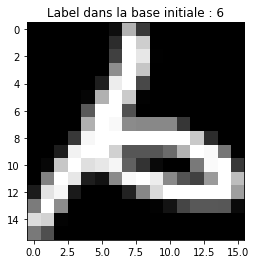

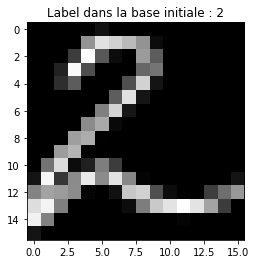

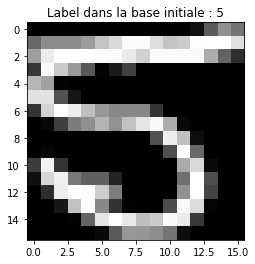

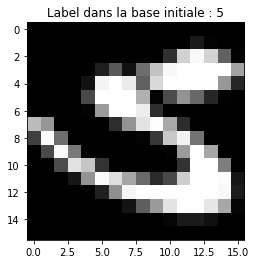

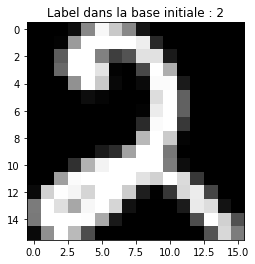

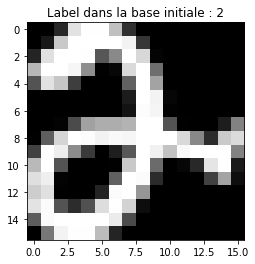

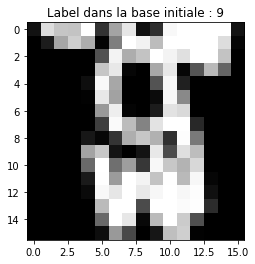

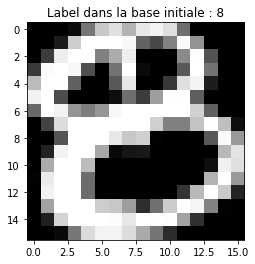

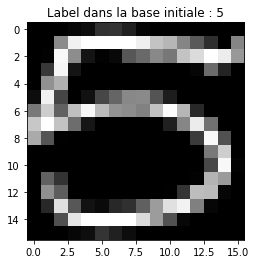

In [9]:
for i in top_outliers.index:
    im_test = top_outliers.ix[i,:]
    label = y_test[top_outliers.index][i]
    im_test = im_test.values.reshape((16, 16))
    plt.title('Label dans la base initiale : {label}'.format(label=label))
    plt.imshow(im_test, cmap='gray')
    plt.show()

### 2.1.2. Méthode OSVM

In [10]:
# Entraînement du modèle OSVM avec nu = 5% comme dans Schölkopf et al. (2001)
nu_value = 0.05
clf = svm.OneClassSVM(nu = nu_value, kernel="rbf")
clf.fit(X)
scores_pred = clf.decision_function(X) # Les scores négatifs sont les outliers

In [11]:
# On affiche de nouveau les 20 pires anomalies selon cette méthode
# c'est à dire ceux dont les scores sont les plus négatifs
X["dist"] = scores_pred.flatten()
top_outliers = X.sort_values("dist", ascending= True).head(20).ix[:,:256]

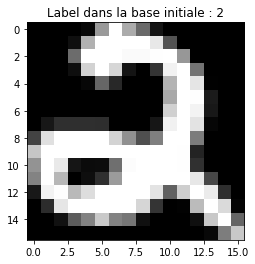

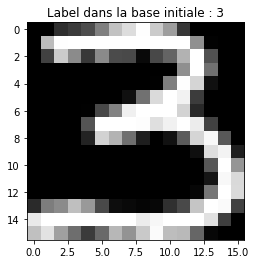

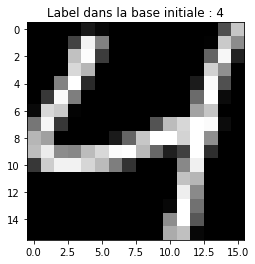

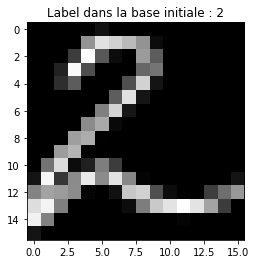

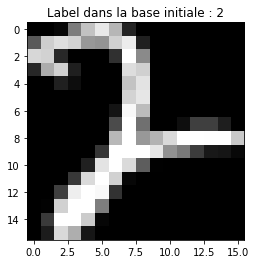

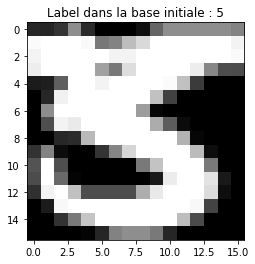

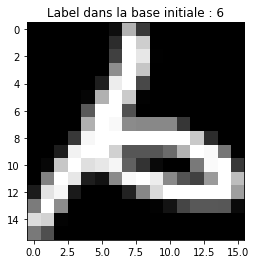

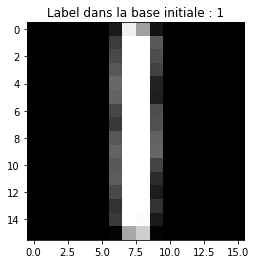

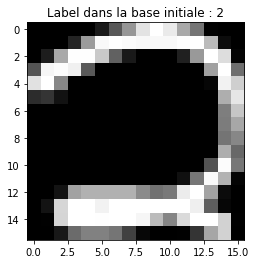

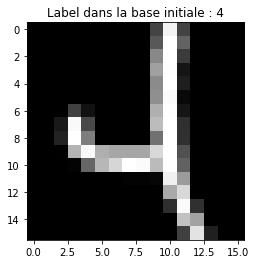

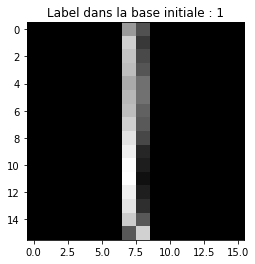

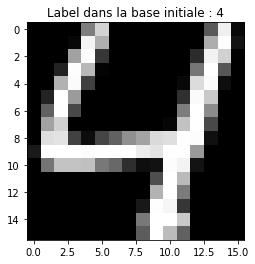

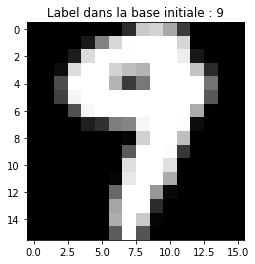

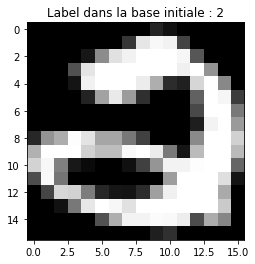

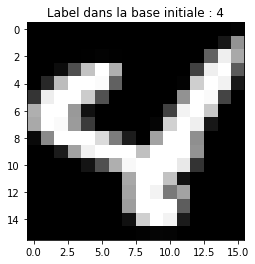

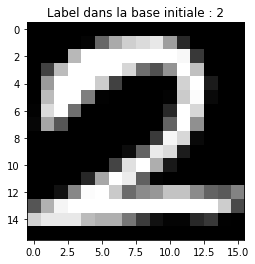

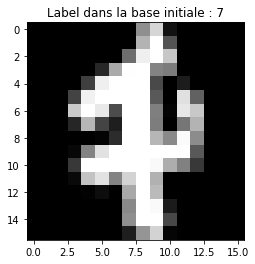

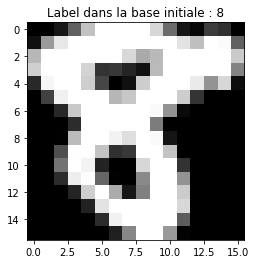

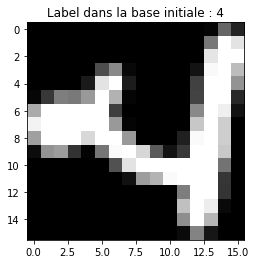

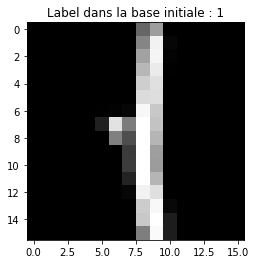

In [12]:
for i in top_outliers.index:
    im_test = top_outliers.ix[i,:]
    label = y_test[top_outliers.index][i]
    im_test = im_test.values.reshape((16, 16))
    plt.title('Label dans la base initiale : {label}'.format(label=label))
    plt.imshow(im_test, cmap='gray')
    plt.show()

## 2.2. Détection de nouveautés

In [13]:
# On ne garde que les 0 pour l'entraînement 
X_test = pd.read_table("zip.test.txt", delim_whitespace = True, header = None)
X_zeros = X_train[X_train[0] == 0].ix[:,1:]

### 2.2.1. Méthode classique basée sur la distance de Mahalanobis

In [14]:
# On estime de nouveau la covariance empirique pour calculer la distance
clf =  EmpiricalCovariance()
clf.fit(asarray(X_zeros))
dist = clf.mahalanobis(asarray(X_test.ix[:,1:]))

In [15]:
# Fonction pour associer un label -1 aux nouveautés et 1 au zéro
def is_old(int):
    if int !=0:
        return -1
    else:
        return 1

In [16]:
X_test["nouveautés_true"] = X_test[0].apply(lambda x: is_old(x))
X_test["nouveautés_dist"] = dist

In [17]:
X_test["nouveautés_true"].value_counts()/X.shape[0]

-1    0.821126
 1    0.178874
Name: nouveautés_true, dtype: float64

In [18]:
# Il y a 17.89% de 0 dans la base test. 
# Ainsi on prend le quantile à 17.89% comme seuil de distance
# Si la distance est sous ce seuil, on prédit 0
# En prenant un autre quantile, comme celui à 50%, le résultat peut être sensiblement dégradé
def dist_thres(int, dist):
    if (int >= np.percentile(dist, 50)):
        return -1
    else:
        return 1

In [19]:
# On obtient donc la prédiction de nouveauté suivante
X_test["nouveautés_preds"] = X_test["nouveautés_dist"].apply(lambda x: dist_thres(x, dist))

[[ 49.0284006   33.08420528]
 [  0.99651221  16.89088191]]


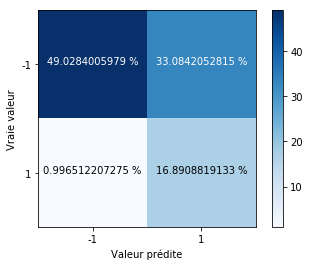

In [20]:
# Matrice de confusion correspondante
cm = (confusion_matrix(X_test["nouveautés_true"], X_test["nouveautés_preds"])/2007)*100
print(cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
classes = [-1,1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Valeur prédite')
plt.ylabel('Vraie valeur')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]) + ' %',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

### 2.2.2. Méthode OSVM

[[ 77.03039362   5.08221226]
 [  1.49476831  16.39262581]]
[[ 81.86347783   0.24912805]
 [  4.78325859  13.10413553]]
[[ 82.11260588   0.        ]
 [ 17.88739412   0.        ]]


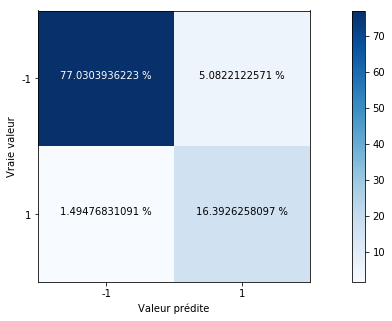

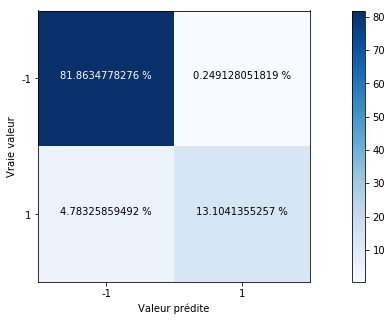

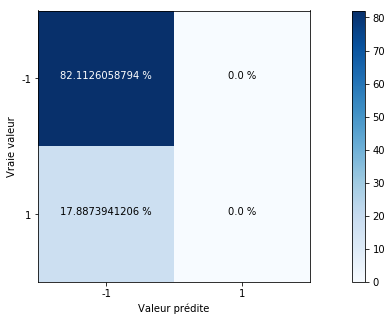

In [21]:
# Pour différentes valeurs de nu:
for nu_value in ([0.01, 0.2, 1]):
    
    # Entraînement de l'OSVM
    X_test = pd.read_table("zip.test.txt", delim_whitespace = True, header = None)
    clf = svm.OneClassSVM(nu = nu_value, kernel="rbf")
    clf.fit(X_zeros)

    # Comparaison avec le vrai label : les classes autre que 0 ont toujours un label de -1
    preds = clf.predict(X_test.ix[:,1:])
    X_test["nouveautés_preds"] = preds
    X_test["nouveautés_true"] = X_test[0].apply(lambda x: is_old(x))

    # Matrice de confusion correspondante
    cm = (confusion_matrix(X_test["nouveautés_true"], X_test["nouveautés_preds"])/2007)*100
    print(cm)
    plt.figure(figsize=(15, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    classes = [-1,1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Valeur prédite')
    plt.ylabel('Vraie valeur')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, str(cm[i, j]) + ' %',
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2. else "black")